# Cost-Weighted Service Loss (CWSL) — Demonstration Notebook  
*A practical walkthrough of asymmetric forecasting metrics for real-world operations*

---

## 1. Introduction

Most traditional forecasting metrics — **MAE, RMSE, MAPE** — assume that over-forecasting and under-forecasting are *equally bad*. But in real operations—especially in **QSR, retail, manufacturing, logistics, and inventory systems**—this is generally not true.

### **Under-forecasting is far more costly:**
- Lost sales  
- Long lines / low throughput  
- Guest dissatisfaction  
- Safety risks & station overload  
- Crew stress  
- Compromised food quality  

### **Over-forecasting is comparatively inexpensive:**
- Extra prep  
- Mild waste or holding costs  

Because of this asymmetry, symmetric metrics fail to tell the true story. 

This notebook demonstrates a metric suite designed for real operational decision-making, centered around **Cost-Weighted Service Loss (CWSL)**.

---

## 2. What This Notebook Demonstrates

This notebook shows:

- How **CWSL, NSL, UD, wMAPE, HR@τ**, and classic metrics behave under different forecast scenarios  
- Why symmetric metrics hide real operational risk  
- How asymmetric metrics reveal *true* model performance  
- Visualizations of both demand patterns and metric responses  
- A reproducible, brand-agnostic demonstration dataset

This notebook is intended as:
- A **teaching notebook**
- A **demo for stakeholders**
- A **metric validation tool**
- A **lightweight benchmark suite** for modeling teams

---

## 3. Demo Dataset Overview

The dataset simulates half-hour intervals from **8:00 AM to 10:00 PM**, representing a typical daily demand cycle:

- Breakfast warmup  
- Lunch peak  
- Afternoon decline  
- Dinner rush  
- Evening taper  

The dataset includes:
- `time` — half-hour interval timestamps  
- `actual_qty` — simulated true demand  
- Three generated forecast scenarios:
  - `forecast_under` — 10% systematic under-forecast  
  - `forecast_over` — 10% systematic over-forecast  
  - `forecast_mixed` — noisy model with random over/under intervals  

These represent the three most common model behaviors seen in real operations.

---

## 4. Why These Scenarios?

### **Scenario 1: Under-Forecasting (10% low)**
Represents a “hot model” that constantly lags true demand.  
Operationally dangerous — often leads to service-level degradation.

### **Scenario 2: Over-Forecasting (10% high)**
Represents a “safe model” that overbuilds slightly.  
Operationally stable — waste increases mildly, but service reliability is high.

### **Scenario 3: Mixed / Noisy Model**
Represents a realistic ML model:
- Sometimes early  
- Sometimes late  
- Sometimes correct  
- Errors cancel out, but reliability is inconsistent

This lets us illustrate:
- How symmetric metrics often judge “noisy but balanced” models as *better*  
- Even when asymmetric metrics reveal the opposite

---

## 5. What We Expect to See

With **cu > co** (underbuilding cost > overbuilding cost):

- **CWSL** should be *worst* for the under-forecast model  
- **NSL** should be *best* for the over-forecast model  
- **UD (Underbuild Depth)** should spike in the under-forecast model  
- **FRS (NSL − CWSL)** should clearly show which forecast is safest  
- **MAE / RMSE / MAPE / wMAPE** will provide little operational insight

Symmetric metrics will misleadingly suggest:

- The under-forecast model isn’t particularly bad  
- The over-forecast model performs similarly to the mixed model  
- All three seem similar on RMSE/MAE

But asymmetric metrics will reveal the “real world” differences sharply.

---

## 6. Visualizing Demand & Forecasts

We plot:
- Actual demand curve  
- Under-forecast (10% low)  
- Over-forecast (10% high)  
- Mixed/noisy forecast  

This lets readers see:
- Which model tracks peaks  
- Which one stays safe  
- Which one wobbles unpredictably  

This visualization anchors the intuition for the metrics.

---

## 7. Visualizing Metric Performance Across Scenarios

We create a grouped bar chart comparing:

- CWSL  
- FRS  
- NSL  
- UD  
- MAE  
- RMSE  
- MAPE  
- wMAPE  

Across:
- Under-forecast
- Over-forecast
- Mixed/noisy forecast

This shows clearly:

- Symmetric metrics fail to penalize under-forecasting  
- Asymmetric metrics highlight service-risk vulnerability  
- FRS gives a single, interpretable score of “forecast readiness”  

---

## 8. Interpretation Guide

### **CWSL (Cost-Weighted Service Loss)**
Lower = better.  
Captures cost asymmetry between under- and over-forecasting.

### **NSL (No-Shortfall Level)**
Higher = better.  
Measures consistency of hitting or exceeding demand.

### **UD (Underbuild Depth)**
Lower = better.  
Shows average severity of shortfalls.

### **FRS (Forecast Readiness Score)**
Higher = better.  
Combines reliability (NSL) and cost risk (CWSL).

### **Symmetric Metrics (MAE, RMSE, MAPE, wMAPE)**
Useful—but blind to operational risk. 

---


In [2]:
import os
import sys

import numpy as np
import pandas as pd

# Manually set the src directory (notebook-safe)
SRC_DIR = os.path.abspath("../src")  # notebook is in examples/
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

from cwsl import cwsl, nsl, ud, wmape, hr_at_tau, frs, mae, rmse, mape

# Load demo actuals data
data_path = os.path.abspath("demo_food_actuals.csv")
df = pd.read_csv(data_path)

df.head()

,time,item,actual_qty
0,08:00,BURGER,6
1,08:00,CHICKEN,4
2,08:00,FRIES,4
3,08:30,BURGER,7
4,08:30,CHICKEN,5


## Constructing Three Forecast Scenarios

To illustrate how CWSL behaves under different forecasting patterns, we create three synthetic forecast models using the same actual demand:

### 1. **Under-Forecast Model (`forecast_under`)**
- Always predicts **10% below** the true demand.
- Represents models that chronically underbuild capacity.
- This should lead to **high CWSL**, **low NSL**, and **high UD**.

### 2. **Over-Forecast Model (`forecast_over`)**
- Always predicts **10% above** the true demand.
- Represents models that consistently overbuild.
- Should show **low shortfall**, **perfect NSL**, and **low CWSL**.
- Traditional metrics (MAE, RMSE, MAPE) treat this as *equally bad* as under-forecasting,
  even though operational impact is different.

### 3. **Mixed / Noisy Model (`forecast_mixed`)**
- Forecast = actual × random noise
- Sometimes short, sometimes long
- Represents a more realistic real-world model
- Should land *between* under and over in both symmetric and asymmetric metrics.

These three give us a clean demonstration that:

> Symmetric metrics (MAE, RMSE, MAPE) cannot differentiate dangerous shortfall patterns,  
> but **CWSL and FRS reveal operational readiness**.

In [3]:
# Create three simple forecast scenarios from actuals

np.random.seed(42)  # for reproducibility

# 1) Systematic under-forecast (10% low)
df["forecast_under"] = (df["actual_qty"] * 0.9).round().astype(int)

# 2) Systematic over-forecast (10% high)
df["forecast_over"] = (df["actual_qty"] * 1.1).round().astype(int)

# 3) Mixed / noisy model (sometimes over, sometimes under)
noise = np.random.normal(loc=1.0, scale=0.10, size=len(df))
df["forecast_mixed"] = (df["actual_qty"] * noise).round().clip(lower=0).astype(int)

df.head()

,time,item,actual_qty,forecast_under,forecast_over,forecast_mixed
0,08:00,BURGER,6,5,7,6
1,08:00,CHICKEN,4,4,4,4
2,08:00,FRIES,4,4,4,4
3,08:30,BURGER,7,6,8,8
4,08:30,CHICKEN,5,4,6,5


In [4]:
# Evaluate all three forecast scenarios in one loop

scenarios = {
    "under": "forecast_under",
    "over": "forecast_over",
    "mixed": "forecast_mixed",
}

cu = 2.0
co = 1.0

results_list = []

for name, col in scenarios.items():
    y_true = df["actual_qty"]
    y_pred = df[col]

    metrics_row = {
        "scenario": name,
        "CWSL": cwsl(y_true, y_pred, cu=cu, co=co),
        "NSL": nsl(y_true, y_pred),
        "UD": ud(y_true, y_pred),
        "wMAPE": wmape(y_true, y_pred),
        "HR@2": hr_at_tau(y_true, y_pred, tau=2),
        "FRS": frs(y_true, y_pred, cu=cu, co=co),
        "MAE": mae(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
    }

    results_list.append(metrics_row)

results_df = pd.DataFrame(results_list)
results_df

,scenario,CWSL,NSL,UD,wMAPE,HR@2,FRS,MAE,RMSE,MAPE
0,under,0.202002,0.044444,1.233333,0.101001,1.000000,-0.157557,1.233333,1.337494,0.104408
1,over,0.101001,1.000000,0.000000,0.101001,1.000000,0.898999,1.233333,1.337494,0.104408
2,mixed,0.101911,0.677778,0.455556,0.064604,0.966667,0.575867,0.788889,1.130388,0.062030


## Visualizing Actual vs Forecast Scenarios

To understand why CWSL behaves differently from symmetric error metrics, it's useful to visually inspect each forecast model.

Below we plot the actual demand for each half-hour interval alongside the three forecasting scenarios:

- **Under-forecast (10% low)** – consistently below actual  
- **Over-forecast (10% high)** – consistently above actual  
- **Mixed model** – fluctuates around actual

This visualization helps show how:

- Under-forecasting creates repeated shortfalls  
- Over-forecasting avoids shortfalls but overbuilds  
- The mixed model behaves realistically but inconsistently  

This plot sets the stage for why **CWSL reacts strongly to shortfalls while symmetric metrics treat the two symmetrically**.

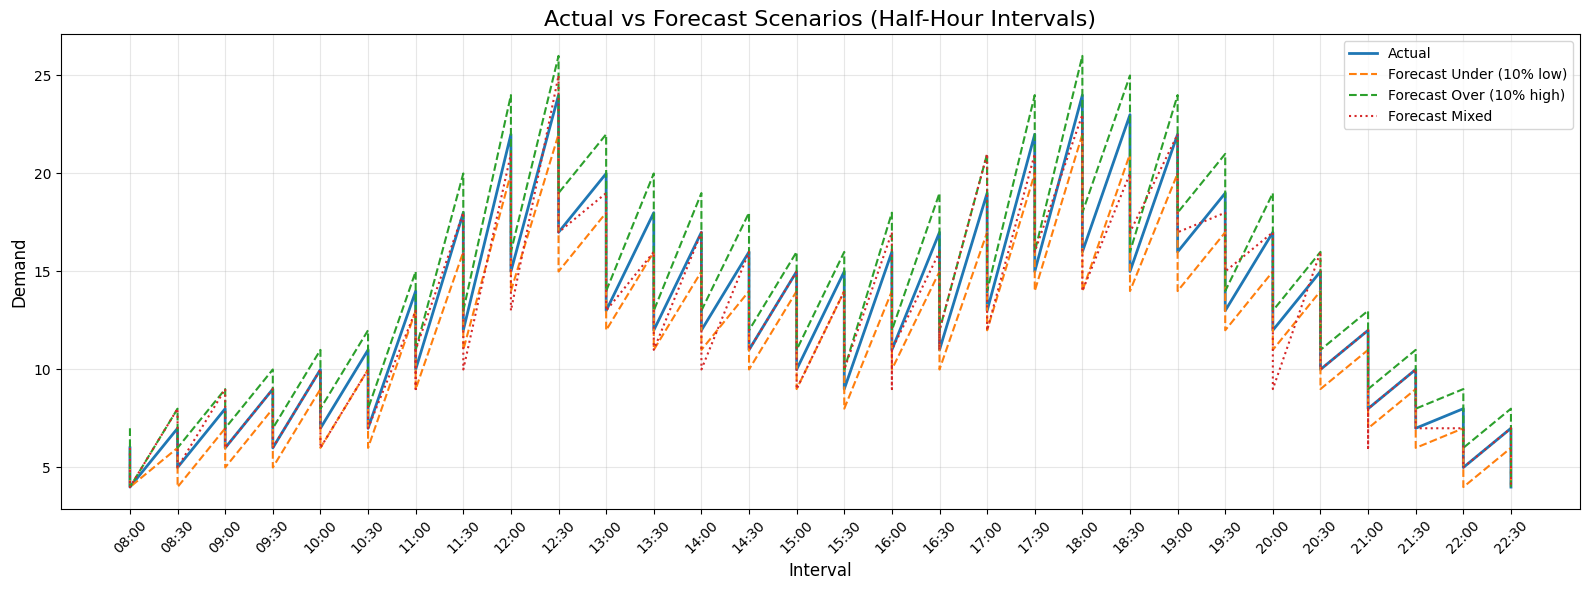

In [5]:
import matplotlib.pyplot as plt

# Ensure time column is a string (for clean x-axis labels)
df["interval"] = df["time"].astype(str)

plt.figure(figsize=(16, 6))

plt.plot(df["interval"], df["actual_qty"], label="Actual", linewidth=2)
plt.plot(df["interval"], df["forecast_under"], label="Forecast Under (10% low)", linestyle="--")
plt.plot(df["interval"], df["forecast_over"], label="Forecast Over (10% high)", linestyle="--")
plt.plot(df["interval"], df["forecast_mixed"], label="Forecast Mixed", linestyle=":")

plt.title("Actual vs Forecast Scenarios (Half-Hour Intervals)", fontsize=16)
plt.xlabel("Interval", fontsize=12)
plt.ylabel("Demand", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

## Comparing Symmetric vs Asymmetric Metrics

Now that we can *see* how each model behaves, we compare the full set of metrics:

- **Symmetric metrics** (MAE, RMSE, MAPE, wMAPE)  
  → treat over-forecasting and under-forecasting as equally bad  
  → cannot distinguish between dangerous shortfalls and harmless overbuilds  

- **Asymmetric metrics** (CWSL, NSL, UD, FRS)  
  → penalize shortfalls more  
  → reward readiness  
  → reveal operationally unsafe patterns that symmetric metrics hide  

The chart below highlights the differences.

<Figure size 1600x600 with 0 Axes>

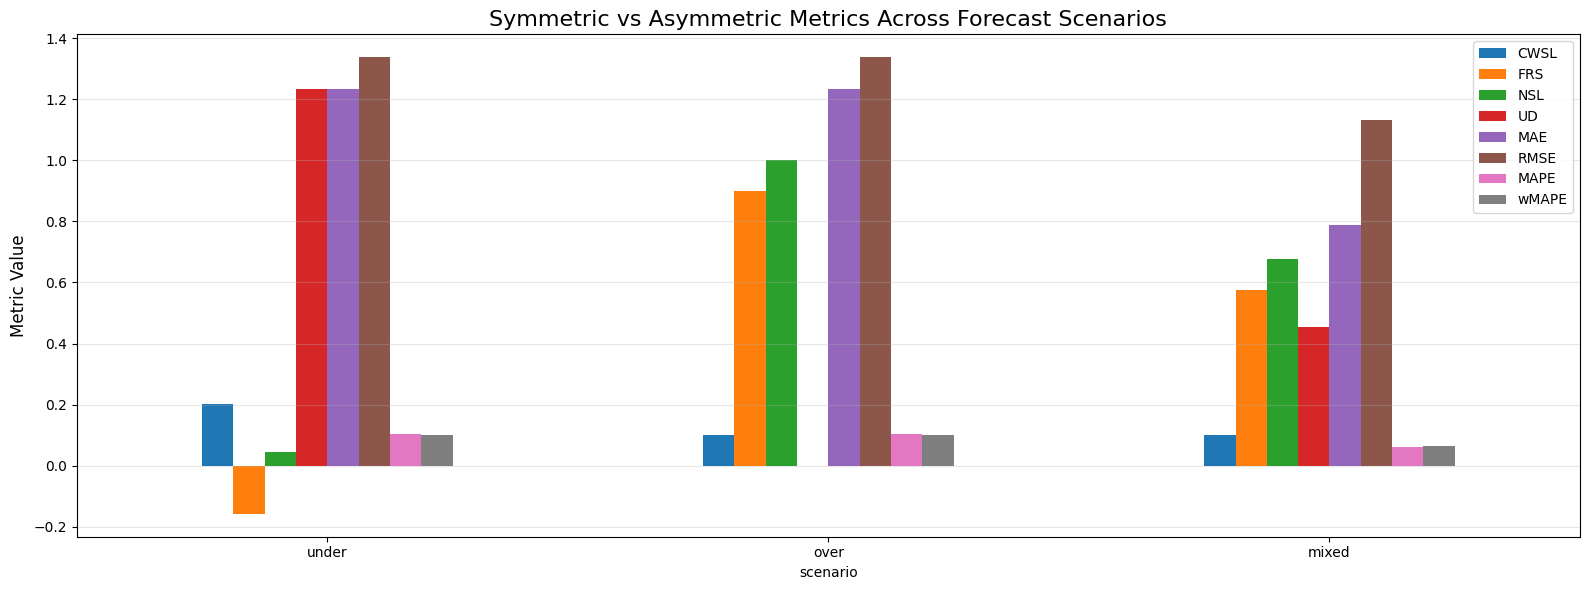

In [6]:
# Create the comparison DataFrame again (if not already available)

scenarios = ["under", "over", "mixed"]
result_rows = []

for scenario in scenarios:
    y_pred = df[f"forecast_{scenario}"]

    result_rows.append({
        "scenario": scenario,
        "CWSL": cwsl(df.actual_qty, y_pred, cu=2.0, co=1.0),
        "NSL": nsl(df.actual_qty, y_pred),
        "UD": ud(df.actual_qty, y_pred),
        "FRS": frs(df.actual_qty, y_pred, cu=2.0, co=1.0),
        "MAE": mae(df.actual_qty, y_pred),
        "RMSE": rmse(df.actual_qty, y_pred),
        "MAPE": mape(df.actual_qty, y_pred),
        "wMAPE": wmape(df.actual_qty, y_pred),
    })

results_df = pd.DataFrame(result_rows)

# Plot
plt.figure(figsize=(16, 6))

metrics_to_plot = ["CWSL", "FRS", "NSL", "UD", "MAE", "RMSE", "MAPE", "wMAPE"]
results_df.set_index("scenario")[metrics_to_plot].plot(kind="bar", figsize=(16, 6))

plt.title("Symmetric vs Asymmetric Metrics Across Forecast Scenarios", fontsize=16)
plt.ylabel("Metric Value", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Conclusions

The CWSL metric suite provides a more realistic and operationally aligned way to evaluate forecasts, especially in environments where the cost of running short is much higher than the cost of running slightly long.

In this demo we saw:

- Under-forecasting looks *acceptable* under MAE/RMSE, but *terrible* under CWSL/UD/NSL  
- Over-forecasting looks *wasteful* under symmetric metrics, but *operationally safe* under asymmetric ones  
- Mixed/noisy models “appear best” under symmetric metrics but have unpredictable service-risk  
- FRS provides a single, interpretable measure for executive and operator communication  

This notebook forms the foundation for:
- Forecast model evaluation  
- Forecast safety scoring  
- Operational model governance  
- Data science handoff to operations teams  
- Productionizing CWSL into forecasting pipelines 

## Comparing Forecast Models
The `compare_forecasts()` function lets us evaluate multiple forecast models 
(under-forecasting, over-forecasting, and mixed/noisy) side by side using all CWSL metrics 
and traditional symmetric metrics.

In [7]:
from cwsl import compare_forecasts

# Actuals as array
y_true = df["actual_qty"].to_numpy()

# Forecast scenarios created earlier in the notebook
forecasts = {
    "under": df["forecast_under"].to_numpy(),
    "over": df["forecast_over"].to_numpy(),
    "mixed": df["forecast_mixed"].to_numpy(),
}

# Cost parameters
cu = 2.0
co = 1.0

# Run comparison
compare_df = compare_forecasts(
    y_true=y_true,
    forecasts=forecasts,
    cu=cu,
    co=co,
    tau=2.0,
)

compare_df.round(3)

,CWSL,NSL,UD,wMAPE,HR@tau,FRS,MAE,RMSE,MAPE
model,,,,,,,,,
under,0.202,0.044,1.233,0.101,1.000,-0.158,1.233,1.337,0.104
over,0.101,1.000,0.000,0.101,1.000,0.899,1.233,1.337,0.104
mixed,0.102,0.678,0.456,0.065,0.967,0.576,0.789,1.130,0.062


## Forecast Model Comparisons (CWSL vs. Symmetric Metrics)

Now that we’ve generated multiple forecast scenarios (systematic under-forecast, over-forecast, and a mixed/noisy model), we can evaluate how each one performs under different types of error metrics.

This section demonstrates a critical point:

### **Symmetric metrics (MAE, RMSE, MAPE, wMAPE) fail to distinguish operationally bad forecasts.**  
They treat being 10 units short the same as 10 units long — which is *not* how real operations work.

In contrast:

### **CWSL + Diagnostics (NSL, UD, HR@τ, FRS) expose shortfall-driven failures that symmetric metrics completely hide.**

---

### **Model Comparison Table**

Below is the full comparison output for all three forecast models:

- **CWSL** — Higher when shortfalls are costly; lower when overbuild is cheap  
- **NSL** — Fraction of intervals with no shortfall  
- **UD** — Depth of underbuild  
- **HR@τ** — Hit rate within a tolerance (here τ = 2 units)  
- **FRS = NSL – CWSL** — Readiness score representing overall reliability  
- **Symmetric metrics** — MAE, RMSE, MAPE, wMAPE

This table reveals a key insight:

- The **over-forecast model** has nearly the same MAE/RMSE/MAPE as the under-forecast model  
- Yet operationally they are *polar opposites*:  
  - Under-forecasting produces low NSL, high UD, and the worst CWSL  
  - Over-forecasting produces perfect NSL, zero UD, and the lowest CWSL

Symmetric metrics completely blur this contrast.

CWSL-based diagnostics clarify it.

---

### **Interpretation Summary**

**Under-Forecast Model**
- Worst CWSL  
- Extremely low NSL  
- Largest UD  
- FRS is negative  
- Symmetric metrics barely detect the problem  

This reflects heavy shortfalls — the scenario operational teams *feel* every day.

**Over-Forecast Model**
- Best CWSL  
- Perfect NSL  
- UD = 0  
- High FRS  
- Symmetric metrics look almost identical to the under-forecast case  

This represents harmless overbuild — cheap, easy, stable.

**Mixed Model**
- Middle performance on both asymmetric and symmetric metrics  
- Reflects realistic forecasting behavior where errors are distributed  

---

### **Why This Matters**

This comparison highlights the entire purpose of the CWSL framework:

- **Operational impact is asymmetric.**  
- **Traditional metrics hide this asymmetry.**  
- **CWSL exposes it with interval-level fidelity.**  

CWSL is not just “another accuracy metric” —  
it is an **operational readiness metric**.

---

You can now proceed to visualize these differences with grouped bar plots or radar charts to make the performance gap even more obvious.

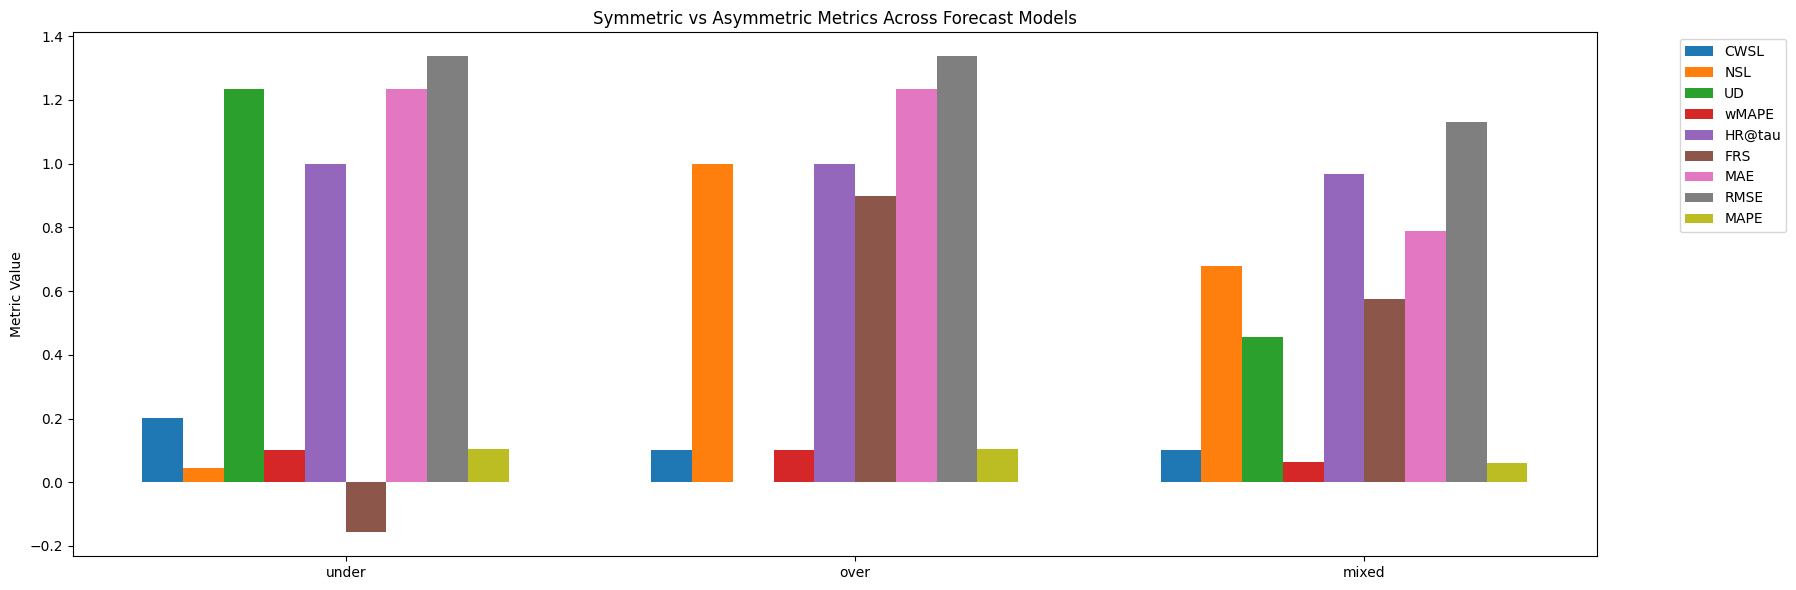

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics_to_plot = ["CWSL", "NSL", "UD", "wMAPE", "HR@tau", "FRS", "MAE", "RMSE", "MAPE"]
models = compare_df.index.tolist()

x = np.arange(len(models))
width = 0.08  # small bars to fit all metrics

plt.figure(figsize=(18, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i * width,
            compare_df[metric],
            width,
            label=metric)

plt.xticks(x + width * len(metrics_to_plot) / 2, models)
plt.ylabel("Metric Value")
plt.title("Symmetric vs Asymmetric Metrics Across Forecast Models")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Symmetric vs Asymmetric Metrics

The bar chart above compares traditional *symmetric* metrics (MAE, RMSE, MAPE, wMAPE)  
against the *asymmetric, operationally grounded* metrics (CWSL, NSL, UD, FRS).

Key takeaways:

- **Under-forecast model**  
  – Symmetrics look “ok”, but UD and CWSL expose severe shortfalls.  
  – NSL is extremely low → the system frequently fails to meet demand.  
  – This is exactly the kind of risk symmetric metrics hide.

- **Over-forecast model**  
  – Symmetric metrics (MAE, RMSE) look *identical* to the under model,  
    proving they cannot detect directionality.  
  – Asymmetric metrics reveal the model is “safe” — no shortfalls, NSL=1.0, UD=0.

- **Mixed model**  
  – Mixed performance across both sides gives a balanced operational profile.  
  – Lower CWSL and higher NSL signal reasonable reliability.

This demonstrates **why symmetric metrics are insufficient**  
and why **CWSL and its companion diagnostics are needed** for real operational forecasting.

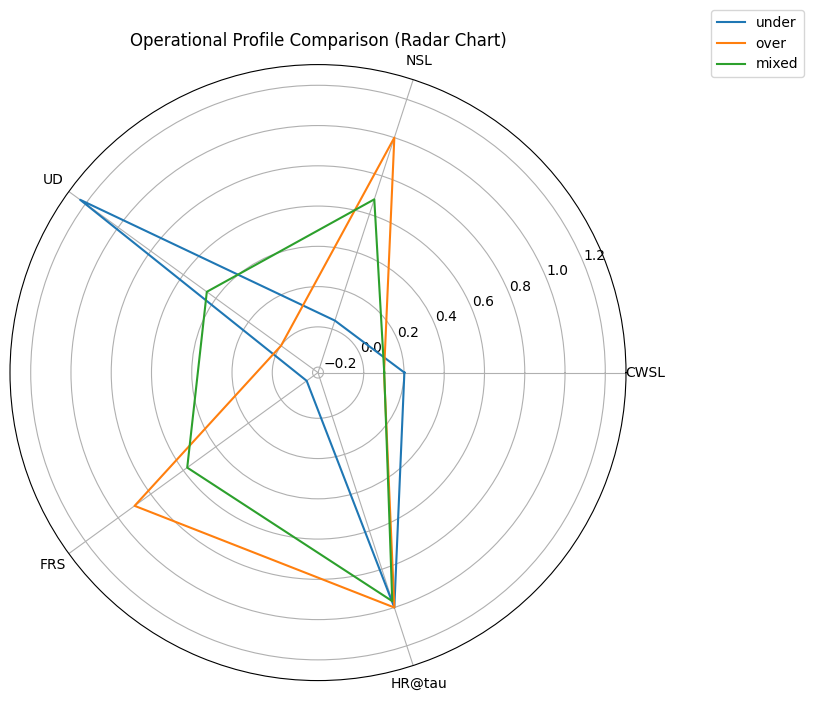

In [10]:
from math import pi
import matplotlib.pyplot as plt

metrics = ["CWSL", "NSL", "UD", "FRS", "HR@tau"]
num_metrics = len(metrics)

angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
angles += angles[:1]  # close the loop

plt.figure(figsize=(8, 8))

for model in compare_df.index:
    values = compare_df.loc[model, metrics].tolist()
    values += values[:1]
    plt.polar(angles, values, label=model)

plt.xticks(angles[:-1], metrics)
plt.title("Operational Profile Comparison (Radar Chart)")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()

### Operational Profile Comparison (Radar Chart)

This radar visualization condenses the asymmetric metrics into a  
single operational “fingerprint” for each forecast model.

Interpretation:

- **Under model**  
  – Huge UD spike reveals deep shortfalls.  
  – Low NSL and negative FRS confirm the model is operationally dangerous.

- **Over model**  
  – NSL = 1.0 and UD = 0 → system is always ready.  
  – FRS high and stable.  
  – Despite higher RMSE/MAE, this model is much safer in practice.

- **Mixed model**  
  – A balanced shape: moderate shortfalls, decent NSL, solid FRS.  
  – Operationally this behaves like a resilient, adaptable forecast.

Radar charts make operational risk visually obvious,  
highlighting how **CWSL-based metrics give structural insight** that symmetric errors cannot.